# Project 2: Ames Housing Data and Kaggle Challenge

## Contents:
- [Recap](#Recap)
- [Setup](#Setup)
- [Loading Data](#Loading-Data)
- [Train, Test, Split](#Train,-Test,-Split)
- [Feature Scaling](#Feature-Scaling)
- [Model Baseline](#Model-Baseline)
- [Model Training](#Model-Training)
- [Production Model](#Production-Model)
- [Overall Evaluation](#Overall-Evaluation)

## Recap

In the previous notebook, we have applied feature engineering in both training and test data. We have also prepared both training and test data for input into machine learning algorithmns.

## Setup
All libraries used should be added here.

In [1]:
# import libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import missingno as msno
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.impute import KNNImputer
import scipy.stats
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib

In [2]:
# path to save the figures
assets_path = '../assets'
os.makedirs(assets_path, exist_ok=True)

# Create a function to save figures
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(assets_path, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Loading Data

Import the datasets required.

In [3]:
# set the input relative paths
input_path = '../datasets_final'

In [4]:
# write a function to load the final training data
def load_housing_train_data(filename='train_final.csv'):
    csv_train_path = os.path.join(input_path, filename)
    return pd.read_csv(csv_train_path)

# write a function to load the final test data
def load_housing_test_data(filename='test_final.csv'):
    csv_test_path = os.path.join(input_path, filename)
    return pd.read_csv(csv_test_path)

In [5]:
train_df = load_housing_train_data()
test_df = load_housing_test_data()

In [6]:
housing = train_df.copy()

### Display data
Let’s take a look at the top five rows using the DataFrame’s head() method.

In [7]:
# check the first five rows
display(housing.head())

,Lot Frontage,Lot Area,Lot Shape,Utilities,Land Slope,Overall Qual,Overall Cond,Mas Vnr Area,Exter Qual,Exter Cond,...,Mo Sold_3,Mo Sold_4,Mo Sold_5,Mo Sold_6,Mo Sold_7,Mo Sold_8,Mo Sold_9,Mo Sold_10,Mo Sold_11,Mo Sold_12
0,4.317488,9.511777,3,4,3,6,8,5.669881,4,3,...,1,0,0,0,0,0,0,0,0,0
1,3.784190,9.349493,3,4,3,7,5,4.890349,4,3,...,0,1,0,0,0,0,0,0,0,0
2,4.234107,8.977525,4,4,3,5,7,0.000000,3,4,...,0,0,0,0,0,0,0,0,0,0
3,4.304065,9.190444,4,4,3,5,5,0.000000,3,3,...,0,1,0,0,0,0,0,0,0,0
4,4.418841,9.563529,3,4,3,6,8,0.000000,3,3,...,1,0,0,0,0,0,0,0,0,0


## Train, Test, Split
Create predictor and target variables.

In [8]:
# target variable is natural log of SalePrice
y = housing['SalePrice']
X = housing.drop(columns = 'SalePrice')

In [9]:
# Train/test split of 80/20
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y, 
    test_size=0.2, 
    random_state=123)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1639, 211) (410, 211) (1639,) (410,)


## Feature Scaling
Machine Learning algorithms don’t perform well when the input numerical attributes have very different scales because they do not give equal contribution to the analysis. Here, we will apply standardisation to get all attributes on the same scale:

* **Standardisation:** Standardisation first subtracts the mean value (so standardised values always have a zero mean), and then it divides by the standard deviation so that the resulting distribution has unit variance. 
    - Scikit-Learn provides a transformer called StandardScaler for standardisation.

In [10]:
dummy_cols = ['Remodeled', 'IsNew', 'HasFence', 'HasPool', 'MS SubClass_20', 'MS SubClass_30', 'MS SubClass_40', 'MS SubClass_45', 'MS SubClass_50', 'MS SubClass_60', 'MS SubClass_70', 'MS SubClass_75', 'MS SubClass_80', 'MS SubClass_85', 'MS SubClass_90', 'MS SubClass_120', 'MS SubClass_150', 'MS SubClass_160', 'MS SubClass_180', 'MS SubClass_190', 'MS Zoning_A (agr)', 'MS Zoning_C (all)', 'MS Zoning_FV', 'MS Zoning_I (all)', 'MS Zoning_RH', 'MS Zoning_RL', 'MS Zoning_RM', 'Street_Grvl', 'Street_Pave', 'Alley_Grvl', 'Alley_None', 'Alley_Pave', 'Land Contour_Bnk', 'Land Contour_HLS', 'Land Contour_Low', 'Land Contour_Lvl', 'Lot Config_Corner', 'Lot Config_CulDSac', 'Lot Config_FR2', 'Lot Config_FR3', 'Lot Config_Inside', 'Neighborhood_Blmngtn', 'Neighborhood_Blueste', 'Neighborhood_BrDale', 'Neighborhood_BrkSide', 'Neighborhood_ClearCr', 'Neighborhood_CollgCr', 'Neighborhood_Crawfor', 'Neighborhood_Edwards', 'Neighborhood_Gilbert', 'Neighborhood_Greens', 'Neighborhood_GrnHill', 'Neighborhood_IDOTRR', 'Neighborhood_Landmrk', 'Neighborhood_MeadowV', 'Neighborhood_Mitchel', 'Neighborhood_NAmes', 'Neighborhood_NPkVill', 'Neighborhood_NWAmes', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_OldTown', 'Neighborhood_SWISU', 'Neighborhood_Sawyer', 'Neighborhood_SawyerW', 'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Neighborhood_Timber', 'Neighborhood_Veenker', 'Condition 1_Artery', 'Condition 1_Feedr', 'Condition 1_Norm', 'Condition 1_PosA', 'Condition 1_PosN', 'Condition 1_RRAe', 'Condition 1_RRAn', 'Condition 1_RRNe', 'Condition 1_RRNn', 'Condition 2_Artery', 'Condition 2_Feedr', 'Condition 2_Norm', 'Condition 2_PosA', 'Condition 2_PosN', 'Condition 2_RRAe', 'Condition 2_RRAn', 'Condition 2_RRNn', 'Bldg Type_1Fam', 'Bldg Type_2fmCon', 'Bldg Type_Duplex', 'Bldg Type_Twnhs', 'Bldg Type_TwnhsE', 'House Style_1.5Fin', 'House Style_1.5Unf', 'House Style_1Story', 'House Style_2.5Fin', 'House Style_2.5Unf', 'House Style_2Story', 'House Style_SFoyer', 'House Style_SLvl', 'Roof Style_Flat', 'Roof Style_Gable', 'Roof Style_Gambrel', 'Roof Style_Hip', 'Roof Style_Mansard', 'Roof Style_Shed', 'Roof Matl_CompShg', 'Roof Matl_Membran', 'Roof Matl_Tar&Grv', 'Roof Matl_WdShake', 'Roof Matl_WdShngl', 'Exterior 1st_AsbShng', 'Exterior 1st_AsphShn', 'Exterior 1st_BrkComm', 'Exterior 1st_BrkFace', 'Exterior 1st_CBlock', 'Exterior 1st_CemntBd', 'Exterior 1st_HdBoard', 'Exterior 1st_ImStucc', 'Exterior 1st_MetalSd', 'Exterior 1st_Plywood', 'Exterior 1st_Stone', 'Exterior 1st_Stucco', 'Exterior 1st_VinylSd', 'Exterior 1st_Wd Sdng', 'Exterior 1st_WdShing', 'Exterior 2nd_AsbShng', 'Exterior 2nd_AsphShn', 'Exterior 2nd_Brk Cmn', 'Exterior 2nd_BrkFace', 'Exterior 2nd_CBlock', 'Exterior 2nd_CmentBd', 'Exterior 2nd_HdBoard', 'Exterior 2nd_ImStucc', 'Exterior 2nd_MetalSd', 'Exterior 2nd_Plywood', 'Exterior 2nd_Stone', 'Exterior 2nd_Stucco', 'Exterior 2nd_VinylSd', 'Exterior 2nd_Wd Sdng', 'Exterior 2nd_Wd Shng', 'Mas Vnr Type_BrkCmn', 'Mas Vnr Type_BrkFace', 'Mas Vnr Type_None', 'Mas Vnr Type_Stone', 'Foundation_BrkTil', 'Foundation_CBlock', 'Foundation_PConc', 'Foundation_Slab', 'Foundation_Stone', 'Foundation_Wood', 'Heating_GasA', 'Heating_GasW', 'Heating_Grav', 'Heating_OthW', 'Heating_Wall', 'Central Air_N', 'Central Air_Y', 'Garage Type_2Types', 'Garage Type_Attchd', 'Garage Type_Basment', 'Garage Type_BuiltIn', 'Garage Type_CarPort', 'Garage Type_Detchd', 'Garage Type_None', 'Misc Feature_Gar2', 'Misc Feature_None', 'Misc Feature_Othr', 'Misc Feature_Shed', 'Misc Feature_TenC', 'Sale Type_COD', 'Sale Type_CWD', 'Sale Type_Con', 'Sale Type_ConLD', 'Sale Type_ConLI', 'Sale Type_ConLw', 'Sale Type_New', 'Sale Type_Oth', 'Sale Type_WD ', 'Yr Sold_2006', 'Yr Sold_2007', 'Yr Sold_2008', 'Yr Sold_2009', 'Yr Sold_2010', 'Mo Sold_1', 'Mo Sold_2', 'Mo Sold_3', 'Mo Sold_4', 'Mo Sold_5', 'Mo Sold_6', 'Mo Sold_7', 'Mo Sold_8', 'Mo Sold_9', 'Mo Sold_10', 'Mo Sold_11', 'Mo Sold_12']

In [11]:
scale_cols = [c for c in X.columns if c not in dummy_cols]

In [12]:
# Scale our data.
# Note we won't be scaling our dummy features
# Relabeling scaled data as "Z" is common.
sc = StandardScaler()

# Make a copy
Z_train = X_train.copy()
Z_test = X_test.copy()

Z_train[scale_cols] = sc.fit_transform(X_train[scale_cols])
Z_test[scale_cols] = sc.transform(X_test[scale_cols])

## Model Baseline
In order to evaluate whether the predictions generated from our algorithm  are good or not, we will need to establish a baseline model. A baseline provides a point of comparison for the more advanced methods that we will evaluate later. Here, we will set our baseline as the mean of y values.

In [13]:
# set  𝑦̂
y_train_mean = y_train.mean()
y_test_mean = y_test.mean()

print(y_train_mean)
print(y_test_mean)

# the mean value of all y values is a good indicator to compare against RMSE.
# if RMSE of the model is worst than the mean value of all y values, 
# then we might as well use the simple mean value instead of the sophisticated modelling

12.027743440048205
12.010882429782399


In [14]:
y_train_mean = np.array([y_train_mean] * y_train.shape[0])
y_test_mean = np.array([y_test_mean] * y_test.shape[0])

In [15]:
# evaulation metrics: Root Mean Squared Error (RMSE), R-squared (r2)
print("---Training Set---")
print('Predicted Train RMSE:', np.sqrt(mean_squared_error(y_train, y_train_mean)))
print('Predicted Train r2:', r2_score(y_train, y_train_mean))
print('\n')
print("---Test Set---")
print('Predicted Test RMSE:', np.sqrt(mean_squared_error(y_test, y_test_mean)))
print('Predicted Test r2:', r2_score(y_test, y_test_mean))

---Training Set---
Predicted Train RMSE: 0.41363587046023775
Predicted Train r2: 0.0


---Test Set---
Predicted Test RMSE: 0.40210690217452555
Predicted Test r2: 0.0


## Model Training

### Fit a Linear Regression model

In [16]:
# Initialise the linear regression model
lr = LinearRegression()  

# Fit model
lr.fit(Z_train, y_train)

# Generate predictions
y_pred_lr_train = lr.predict(Z_train)
y_pred_lr = lr.predict(Z_test)

## Evaulation metrics: Root Mean Squared Error (RMSE), R-squared (r2)
# Testing on training data
print("---Training Set---")
print('Predicted Train RMSE:', np.sqrt(mean_squared_error(y_train,y_pred_lr_train)))
print('Predicted Train r2:', r2_score(y_train, y_pred_lr_train))
print('\n')
# Testing on unseen data
print("---Test Set---")
print('Predicted Test RMSE:', np.sqrt(mean_squared_error(y_test, y_pred_lr)))
print('Predicted Test r2:', r2_score(y_test, y_pred_lr))

---Training Set---
Predicted Train RMSE: 0.10401130175766223
Predicted Train r2: 0.9367697824141038


---Test Set---
Predicted Test RMSE: 0.12174319763071141
Predicted Test r2: 0.9083344067981594


### Cross-validate the RMSE of the linear regression model

In [17]:
# Perform cross-validation
linreg_scores = -cross_val_score(lr, Z_train, y_train, cv=5, scoring ='neg_root_mean_squared_error')
print("Cross-validated scores:", linreg_scores)
print("Mean CV RMSE:", np.mean(linreg_scores))

Cross-validated scores: [1.44150290e+01 1.20586764e-01 5.36947481e+10 8.39043480e+09
 2.92549209e+10]
Mean CV RMSE: 18268020762.451725


It is clear that the linear regression model test results are worse than training. This suggests overfitting of training data when more data are reserved for training, as the model doesn't work as well on unseen data. Furthermore, the RMSE of the linear regression model ended up exploding and performed worst off as compared the RMSE of baseline. Hence, the linear regression model did not outperform the baseline.

### Fit a Ridge Regression model
Fit the ridge regression with default parameters.

In [18]:
# Initialise the ridge regression model
ridge = Ridge()

# fit the model
ridge.fit(Z_train, y_train)

# Generate predictions
y_pred_ridge_train = ridge.predict(Z_train)
y_pred_ridge = ridge.predict(Z_test)

## Evaulation metrics: Root Mean Squared Error (RMSE), R-squared (r2)
# Testing on training data
print("---Training Set---")
print('Predicted Train RMSE:', np.sqrt(mean_squared_error(y_train,y_pred_ridge_train)))
print('Predicted Train r2:', r2_score(y_train, y_pred_ridge_train))
print('\n')
# Testing on unseen data
print("---Test Set---")
print('Predicted Test RMSE:', np.sqrt(mean_squared_error(y_test, y_pred_ridge)))
print('Predicted Test r2:', r2_score(y_test, y_pred_ridge))

---Training Set---
Predicted Train RMSE: 0.10561086203239431
Predicted Train r2: 0.9348100290345077


---Test Set---
Predicted Test RMSE: 0.10980790892996395
Predicted Test r2: 0.925426558299149


Find an optimal value for the ridge regression alpha using `RidgeCV`.

In [19]:
# Set up a list of ridge alphas to check.
# np.logspace generates 100 values equally between 0 and 5,
# then converts them to alphas between 10^0 and 10^5.
r_alpha = np.logspace(0,5,100)

# Instantiate model.
ridge_cv = RidgeCV(alphas = r_alpha, scoring= 'neg_root_mean_squared_error' , cv= 5)

# Fit model using optimal alpha.
ridge_cv = ridge_cv.fit(Z_train, y_train)

In [20]:
# Here is the optimal value of alpha
ridge_cv.alpha_

23.101297000831593

In [21]:
# Generate predictions.
y_pred_ridge_tuned_train =  ridge_cv.predict(Z_train)
y_pred_ridge_tuned =  ridge_cv.predict(Z_test)

## Evaulation metrics: Root Mean Squared Error (RMSE), R-squared (r2)
# Testing on training data
print("---Training Set---")
print('Predicted Train RMSE:', np.sqrt(mean_squared_error(y_train,y_pred_ridge_tuned_train)))
print('Predicted Train r2:', r2_score(y_train, y_pred_ridge_tuned_train))
print('\n')
# Testing on unseen data
print("---Test Set---")
print('Predicted Test RMSE:', np.sqrt(mean_squared_error(y_test, y_pred_ridge_tuned)))
print('Predicted Test r2:', r2_score(y_test, y_pred_ridge_tuned))

---Training Set---
Predicted Train RMSE: 0.11079862222766487
Predicted Train r2: 0.9282482772924247


---Test Set---
Predicted Test RMSE: 0.10674233985697802
Predicted Test r2: 0.9295322538057904


### Cross-validate the ridge regression RMSE with the optimal alpha.

In [22]:
ridge = Ridge(alpha=ridge_cv.alpha_)
ridge_scores = -cross_val_score(ridge, Z_train, y_train, cv=5 , scoring= 'neg_root_mean_squared_error' )

print ("Cross-validated scores:",  ridge_scores)
print ("Mean CV RMSE:", np.mean(ridge_scores))

Cross-validated scores: [0.12354568 0.11501184 0.15305065 0.11678546 0.10739694]
Mean CV RMSE: 0.12315811477681553


We can see that the ridge regression model fits well on both training and test set. Ridge regression performed much better than linear regression, and it even outperformed the baseline. Ridge regression is able to handle multicolinearity issue by setting the coefficients of correlated predictors to similar values.

### Fit a Lasso Regression model
Fit the lasso regression with default parameters.

In [23]:
# Initialise the lasso regression model
lasso = Lasso(max_iter=30000)

# fit the model
lasso.fit(Z_train, y_train)

# Generate predictions
y_pred_lasso_train = lasso.predict(Z_train)
y_pred_lasso = lasso.predict(Z_test)

## Evaulation metrics: Root Mean Squared Error (RMSE), R-squared (r2)
# Testing on training data
print("---Training Set---")
print('Predicted Train RMSE:', np.sqrt(mean_squared_error(y_train,y_pred_lasso_train)))
print('Predicted Train r2:', r2_score(y_train, y_pred_lasso_train))
print('\n')
# Testing on unseen data
print("---Test Set---")
print('Predicted Test RMSE:', np.sqrt(mean_squared_error(y_test, y_pred_lasso)))
print('Predicted Test r2:', r2_score(y_test, y_pred_lasso))

---Training Set---
Predicted Train RMSE: 0.41363587046023775
Predicted Train r2: 0.0


---Test Set---
Predicted Test RMSE: 0.4024602520045641
Predicted Test r2: -0.0017582641854738679


Find an optimal value for the lasso regression alpha using `LassoCV`.

In [24]:
# Instantiate model
lasso_cv = LassoCV(n_alphas=100, cv=5, max_iter=30000)

# Fit model using optimal alpha.
lasso_cv = lasso_cv.fit(Z_train, y_train)

In [25]:
# Here is the optimal value of alpha
lasso_cv.alpha_

0.000787466392895743

In [26]:
# Generate predictions.
y_pred_lasso_tuned_train =  lasso_cv.predict(Z_train)
y_pred_lasso_tuned =  lasso_cv.predict(Z_test)

## Evaulation metrics: Root Mean Squared Error (RMSE), R-squared (r2)
# Testing on training data
print("---Training Set---")
print('Predicted Train RMSE:', np.sqrt(mean_squared_error(y_train,y_pred_lasso_tuned_train)))
print('Predicted Train r2:', r2_score(y_train, y_pred_lasso_tuned_train))
print('\n')
# Testing on unseen data
print("---Test Set---")
print('Predicted Test RMSE:', np.sqrt(mean_squared_error(y_test, y_pred_lasso_tuned)))
print('Predicted Test r2:', r2_score(y_test, y_pred_lasso_tuned))

---Training Set---
Predicted Train RMSE: 0.11492564079033954
Predicted Train r2: 0.9228035230918824


---Test Set---
Predicted Test RMSE: 0.10694793705208551
Predicted Test r2: 0.9292605355040277


### Cross-validate the lasso regression RMSE with the optimal alpha.

In [27]:
lasso = Lasso(alpha=lasso_cv.alpha_)
lasso_scores = -cross_val_score(lasso, Z_train, y_train, cv=5 , scoring= 'neg_root_mean_squared_error')

print ("Cross-validated scores:", lasso_scores)
print ("Mean CV RMSE:", np.mean(lasso_scores))

Cross-validated scores: [0.12669522 0.11675171 0.15480123 0.11640095 0.10579147]
Mean CV RMSE: 0.12408811804339819


We can see that the lasso regression model fits well on both training and test set.  Although lasso regression performed much better than the linear regression and the baseline, it performed slightly worse off than ridge regression. This is probably because lasso regression handle multicolinearity issue by choosing the "best" of the correlated variables and zero-out the other redundant ones. 

Given that ridge regression works better than lasso regression, we can infer that most predictors impact our target variable, natural log of SalePrice.

### Fit a Elastic Net Regression model
Fit the elastic net regression with default parameters.

In [28]:
# Initialise the lasso regression model
enet = ElasticNet()

# fit the model
enet.fit(Z_train, y_train)

# Generate predictions
y_pred_enet_train = enet.predict(Z_train)
y_pred_enet = enet.predict(Z_test)

## Evaulation metrics: Root Mean Squared Error (RMSE), R-squared (r2)
# Testing on training data
print("---Training Set---")
print('Predicted Train RMSE:', np.sqrt(mean_squared_error(y_train,y_pred_enet_train)))
print('Predicted Train r2:', r2_score(y_train, y_pred_enet_train))
print('\n')
# Testing on unseen data
print("---Test Set---")
print('Predicted Test RMSE:', np.sqrt(mean_squared_error(y_test, y_pred_enet)))
print('Predicted Test r2:', r2_score(y_test, y_pred_enet))

---Training Set---
Predicted Train RMSE: 0.41363587046023775
Predicted Train r2: 0.0


---Test Set---
Predicted Test RMSE: 0.4024602520045641
Predicted Test r2: -0.0017582641854738679


Find an optimal value for the elastic net regression alpha and l1 ratio using `ElasticNetCV`.

In [29]:
# Set up our l1 ratio
enet_ratio = np.linspace(0.01, 1, 250)

# Instantiate model.
enet_cv = ElasticNetCV(n_alphas=100, l1_ratio=enet_ratio, cv=5)

# Fit model using optimal alpha.
enet_cv = enet_cv.fit(Z_train, y_train)

In [30]:
# Here is the optimal value of alpha
enet_cv.alpha_

0.015545416738069346

In [31]:
# Here is the optimal value of l1_ratio
enet_cv.l1_ratio_

0.021927710843373492

In [32]:
# Generate predictions.
y_pred_enet_tuned_train =  enet_cv.predict(Z_train)
y_pred_enet_tuned =  enet_cv.predict(Z_test)

## Evaulation metrics: Root Mean Squared Error (RMSE), R-squared (r2)
# Testing on training data
print("---Training Set---")
print('Predicted Train RMSE:', np.sqrt(mean_squared_error(y_train,y_pred_enet_tuned_train)))
print('Predicted Train r2:', r2_score(y_train, y_pred_enet_tuned_train))
print('\n')
# Testing on unseen data
print("---Test Set---")
print('Predicted Test RMSE:', np.sqrt(mean_squared_error(y_test, y_pred_enet_tuned)))
print('Predicted Test r2:', r2_score(y_test, y_pred_enet_tuned))

---Training Set---
Predicted Train RMSE: 0.11405185648113327
Predicted Train r2: 0.9239729165461447


---Test Set---
Predicted Test RMSE: 0.10660406389136776
Predicted Test r2: 0.929714705949672


### Cross-validate the elastic net regression RMSE with the optimal alpha and l1_ratio.

In [33]:
enet = ElasticNet(alpha=enet_cv.alpha_, l1_ratio=enet_cv.l1_ratio_)
enet_scores = -cross_val_score(enet, Z_train, y_train, cv=5 , scoring= 'neg_root_mean_squared_error')

print ("Cross-validated scores:", enet_scores)
print ("Mean CV RMSE:", np.mean(enet_scores))

Cross-validated scores: [0.12430394 0.11553317 0.15363103 0.11619915 0.10690013]
Mean CV RMSE: 0.12331348479948179


We can see that the elastic net regression model fits well on both training and test set. Although elastic net regression performed better than lasso regression, it did not performed better than ridge regression.

## Production Model

In [34]:
print('5-fold CV results for Linear Regression model: ', np.mean(linreg_scores))
print('5-fold CV results for Ridge Regression model: ', np.mean(ridge_scores))
print('5-fold CV results for Lasso Regression model: ', np.mean(lasso_scores))
print('5-fold CV results for Elastic Net Regression model: ', np.mean(enet_scores))

5-fold CV results for Linear Regression model:  18268020762.451725
5-fold CV results for Ridge Regression model:  0.12315811477681553
5-fold CV results for Lasso Regression model:  0.12408811804339819
5-fold CV results for Elastic Net Regression model:  0.12331348479948179


After applying 5-folds cross validation, it is clear that Ridge Regression model has the best performance in terms of RMSE score and it outperformed the baseline. Hence, we will use Ridge Regression to create our production model.

Saving figure ridge_predictions_vs_original


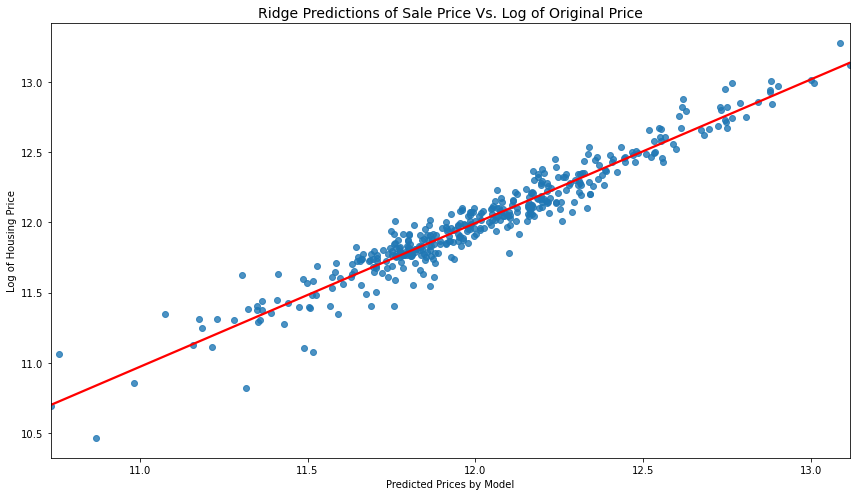

In [35]:
# plot the predictions
plt.figure(figsize=(12,7))
g = sns.regplot(x=y_pred_ridge_tuned, y=y_test, ci=False, fit_reg = True)

regline = g.get_lines()[0]
regline.set_color('red')

plt.xlabel("Predicted Prices by Model")
plt.ylabel("Log of Housing Price")
plt.title("Ridge Predictions of Sale Price Vs. Log of Original Price", fontsize=14)

save_fig("ridge_predictions_vs_original")
plt.show()

We can see that the line of best fit passes through most of the points.

Saving figure ridge_residual_plot


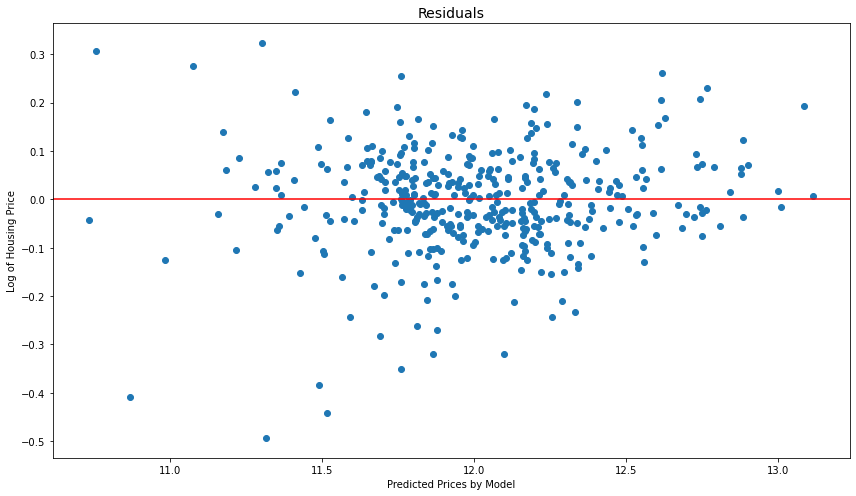

In [36]:
# plot residuals
plt.figure(figsize=(12,7))
plt.scatter(x=y_pred_ridge_tuned, y=y_test-y_pred_ridge_tuned)
plt.axhline(0, c='r')

plt.xlabel("Predicted Prices by Model")
plt.ylabel("Log of Housing Price")
plt.title("Residuals", fontsize=14)

save_fig("ridge_residual_plot")
plt.show()

The residual plot shows a fairly random pattern - supports the assumption of linear model. We are able to see a consistent variance between our low predictions and our high predictions (homoscedasticity).

### Look at the coefficients for variables in the Ridge Regression

In [37]:
sorted(abs(ridge_cv.coef_), reverse = True)

[0.08071305475688936,
 0.07840157727003899,
 0.0621931334482535,
 0.05561215652658395,
 0.05431432991414185,
 0.054311282357066795,
 0.05159087523570255,
 0.046901007427390576,
 0.0465077307063863,
 0.04593689381323058,
 0.044041093494760625,
 0.04319437496636914,
 0.04299062830484594,
 0.041332389416119095,
 0.04018546231738093,
 0.03515096168377399,
 0.03480307655788746,
 0.033851636611544354,
 0.031163691120780462,
 0.03099179461641899,
 0.0309882232657092,
 0.03071773536093421,
 0.030148222449203628,
 0.02911276373208671,
 0.02883513051858897,
 0.02795638376682566,
 0.02628079106899288,
 0.02590002070974755,
 0.025276899685064125,
 0.02481285224252573,
 0.023985844621471217,
 0.023487328454830127,
 0.02345946225088477,
 0.022627695480799445,
 0.022030286444817505,
 0.02166019738110891,
 0.021131759507246228,
 0.020961234312115065,
 0.020001263752532736,
 0.019979946308941086,
 0.01996916766991447,
 0.01983422637341305,
 0.019410130933706093,
 0.019330063151282252,
 0.01927869095879

In [38]:
print("Number of coefficients that are zero-ed out:", len([i for i in abs(ridge_cv.coef_) if i == 0]))
print("Total number of coefficents:", len(abs(ridge_cv.coef_)))
print("Percentage of coefficients that are zero-ed out: {:.2f} %".format((len([i for i in abs(ridge_cv.coef_)if i == 0.0])/len(abs(ridge_cv.coef_)))*100))

Number of coefficients that are zero-ed out: 0
Total number of coefficents: 211
Percentage of coefficients that are zero-ed out: 0.00 %


#### Features of Importance
The top 25 most important predictors:

Saving figure top_25_predictors


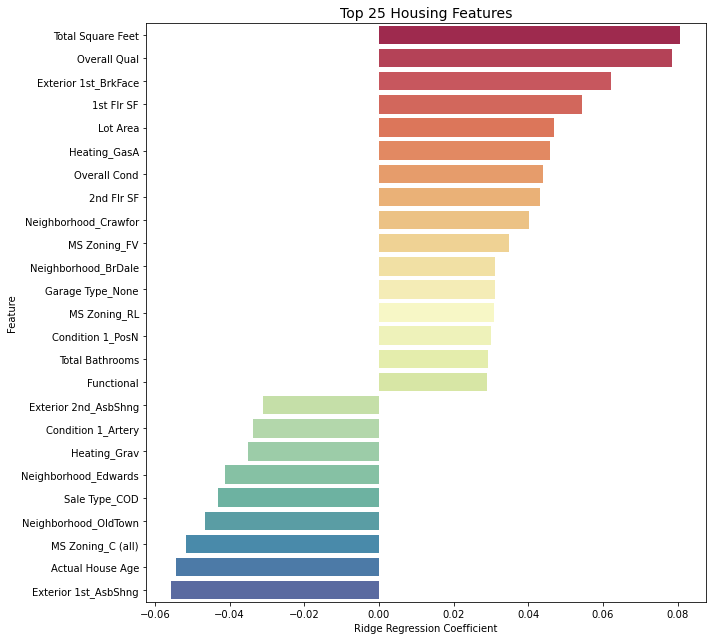

In [39]:
# Create dataframe of features, coefficients and absolute coefficients
ridge_df = pd.DataFrame(columns=['Feature', 'Coef', 'Abs Coef'])
ridge_df['Abs Coef'] = abs(ridge_cv.coef_)
ridge_df['Coef'] = ridge_cv.coef_
ridge_df['Feature'] = X.columns

# Plot top 10 features (sorted by absolute regression coefficient)
plt.figure(figsize=(10,9))
data = ridge_df.sort_values(by='Abs Coef', ascending=False).head(25)[['Feature', 'Coef']] \
               .sort_values(by='Coef', ascending=False).reset_index(drop=True)
    
ax = sns.barplot(data=data, y='Feature', x='Coef', orient='h', palette='Spectral')
ax.set_yticklabels(data['Feature'])
ax.set_xlabel('Ridge Regression Coefficient')
plt.title('Top 25 Housing Features', fontsize=14)

save_fig("top_25_predictors")

The top predictive features that we see here are very plausible. The model coefficients imply that the ten largest effects on house prices in Ames were (in descending order) the total square feet (positive), overall quality (positive), houses with brick face exterior (positive), houses with asbestos shingles exterior (negative), 1st floor square feet (positive), actual house age (negative), properties zoned as commerical (negative), lot area (postive), houses located in Old Town (negative), and houses with forced air heating system (postive).

#### Model interpretation

In [40]:
# set index
ridge_df.set_index('Feature', inplace=True)

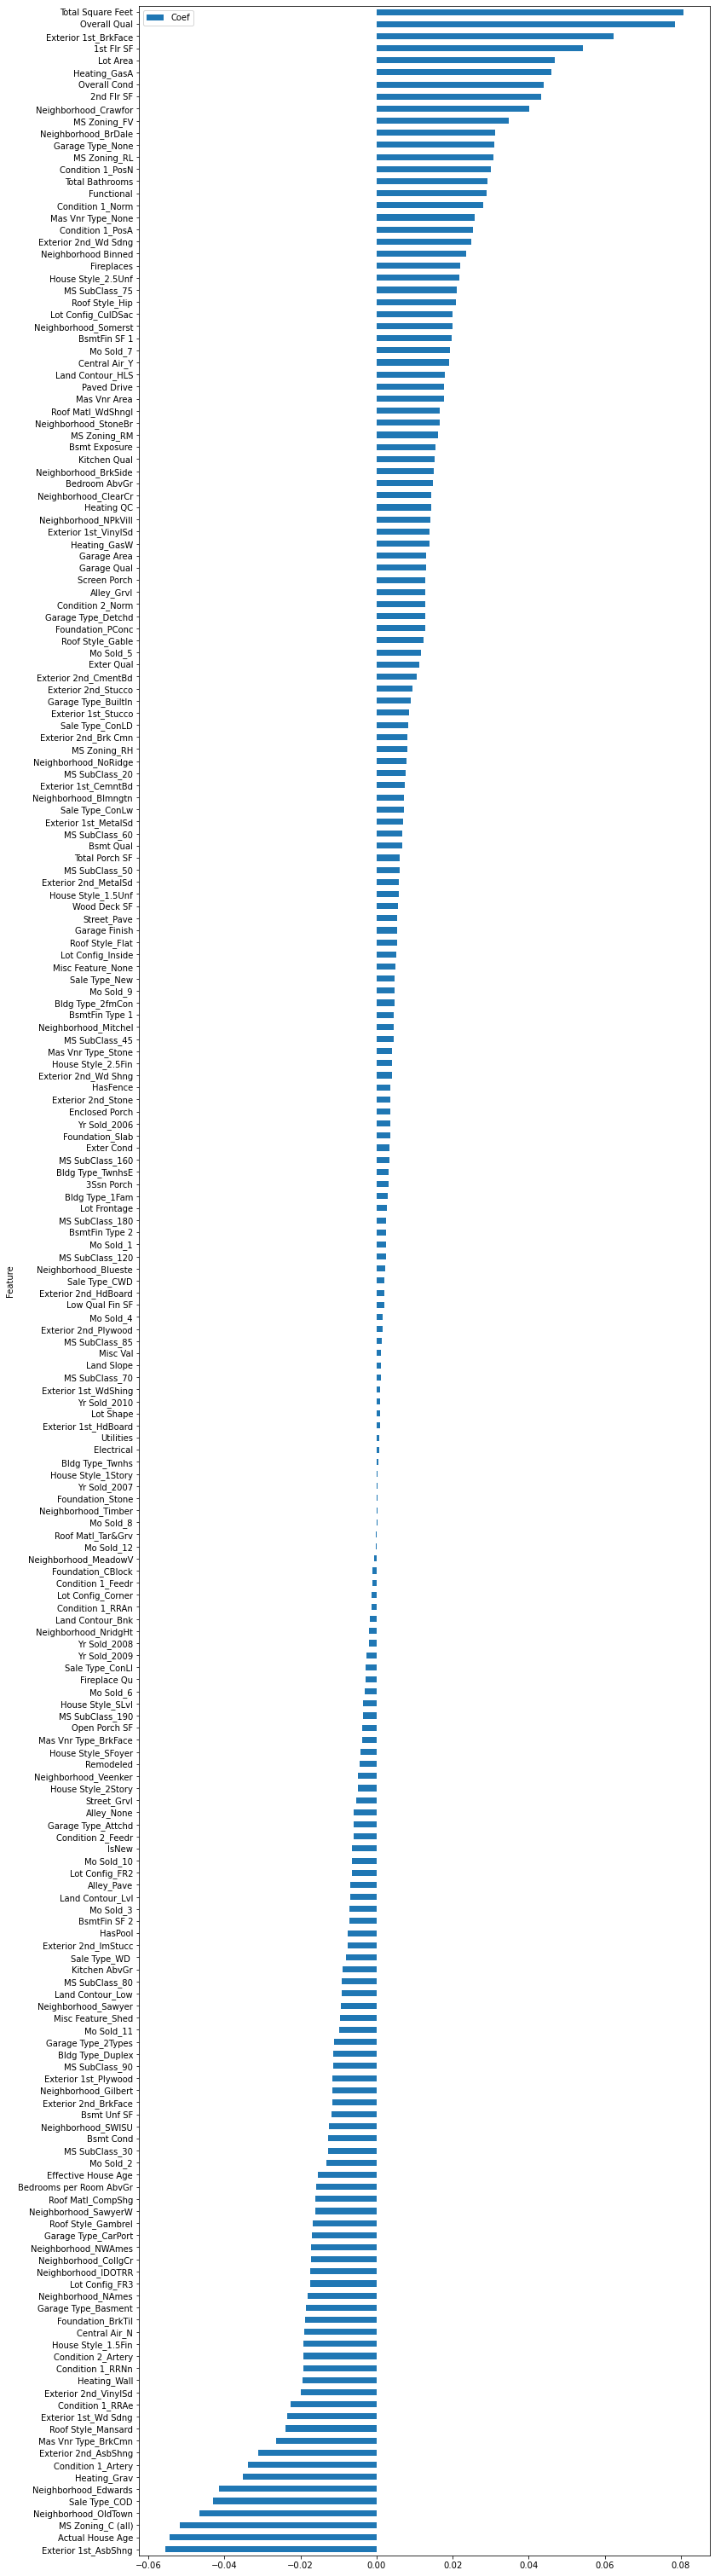

In [41]:
# Plot all features and lasso coefficients
ridge_df[['Coef']].sort_values(by='Coef').plot.barh(figsize=(12,55))
plt.show()

In [42]:
ridge_cv.intercept_

11.900392350452481

Written as an equation, we can describe the model:

$$ log(SalePrice) = \beta_0 + \beta_1  * log(Total Square Feet) + \beta_2 * (Overall Qual) +... + \beta_i * X_i +  \varepsilon$$

$$ = 11.90 + 0.0807 * log(Total Square Feet) + 0.0784 * (Overall Qual) +... + \beta_i * X_i +  \varepsilon$$

where, 
* $\beta_0$: Intercept
* $\beta_i$: Slope for $X_i$
* $X$: Independent variables (Predictors)
* $\varepsilon$: Error

For overall quality, we can say that for a one-unit increase in overall quality holding other variables constant, we expect to see about 8.2% of increase in the geometric mean of SalePrice since exp(0.0784) = 1.082.

Focusing on the effect of Total Square Feet and holding other variables constant, we can say that for any 1% increase in Total Square Feet, the expected ratio of SalePrice is approximately $(1 + 0.01)^{0.0807}$ = 1.0008. In other words, we expect about 0.08% increase in SalePrice when Total Square Feet increases by 1%.

## Overall Evaluation
Based on the insights from our exploratory data analysis (EDA), we zoomed in on the various features that are likely to influence SalePrice. There followed by data cleaning, preprocessing and feature engineering to prepare our data for model training. We also undertook a log transformation of the highly skewed SalePrice target variable.

We tried to predict the SalePrice of a house with regression models. The engineered data was then run through four regression algorithms:
* Linear
* Lasso
* Ridge
* Elastic Net

After applying 5-folds cross validation, it is clear that Ridge Regression model has the best performance in terms of RMSE score and it outperformed the baseline. Hence, we chose the Ridge Regression to create our production model.

### Recommendations
Recall that the housing prices are currently estimated manually by a team of experts. Based on our model, we would recommend the following to the experts who are looking into improving their manual estimation on housing prices:
* The assorted property size variables, namely total square feet, lot area, 1st floor square feet, and 2nd floor square feet, are important determinants of increasing house prices. 
* Similarly, build quality and condition are among the important determinants of increasing house prices.
* Neighborhoods such as Crawford & Briardale are good investments, while Old Town is a bad investment.
* Asbestos shingles exterior can severely impact on the value of a home.
* Older homes are valued at lower prices, as the value depreciates over time.


### Limitations
Although our production model generalises well to the houses sold in Ames, Iowa, it probably will not generalise well to other cities, given that each city tends to differ greatly in terms of geographical features, climatic conditions, and cultural preferences.

Another point to note is that this model works well for houses sold from 2006 to 2010. Housing prices would have varied over the years. Hence, our model would need to be retrained using more recent data.

### Future Steps

We could try dropping some of the less useful features/ try out other machine learning algorithmns to improve model performance. After tweaking the production model for a while, we will eventually have a system that performs sufficiently well. Thereafter, we will want to test our model for deployment by evaluating against the experts’ price estimate. Finally, we will need to present our solution to the management for approval to launch the model. When the model is eventually launched into production, it will help to free up some time for the team of experts who are manually estimating housing prices, so that they can use their expertise on more productive tasks.